In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.preprocessing import LabelEncoder


In [2]:
df = pd.read_csv('../data/data_cleaned.csv', sep=',')

In [3]:
# encode target variable: 0: dropout, 1: enrolled, 2: graduated
le = LabelEncoder()
df['Target_encoded'] = le.fit_transform(df['Target'])

# Drop 'Target' variable
df.drop('Target', axis = 1, inplace = True)

In [4]:
# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation','Target_encoded']

df[col] = df[col].astype('category')

In [43]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   int64   
 3   Course                                        4424 non-null   category
 4   Daytime/evening_attendance                    4424 non-null   int64   
 5   Previous_qualification                        4424 non-null   category
 6   Previous_qualification_grade                  4424 non-null   float64 
 7   Nationality                                   4424 non-null   int64   
 8   Mother_qualification                          4424 non-null   category
 9   Father_qualification                          4424 n

# Drop Values

In [44]:
cats = df.select_dtypes(include=['category']).columns.tolist()
print(cats)

['Marital_status', 'Application_mode', 'Course', 'Previous_qualification', 'Mother_qualification', 'Father_qualification', 'Mother_occupation', 'Father_occupation', 'Target_encoded']


In [5]:
stud_selected = df.drop(['Nationality', 'International', 'Educational_special_needs'], axis = 1)  

In [31]:
stud_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   int64   
 3   Course                                        4424 non-null   category
 4   Daytime/evening_attendance                    4424 non-null   int64   
 5   Previous_qualification                        4424 non-null   category
 6   Previous_qualification_grade                  4424 non-null   float64 
 7   Mother_qualification                          4424 non-null   category
 8   Father_qualification                          4424 non-null   category
 9   Mother_occupation                             4424 n


| **Prestazione media**    Compatta le due note in un’unica metrica di qualità.     
                                                          
| **Efficienza**          Normalizzi per il numero di unità: evita che chi segue più corsi sembri “peggiore” solo perché ha più valutazioni. 

| **Trend / miglioramento** Cattura se lo studente recupera o peggiora; spesso è più predittivo del valore assoluto.    
                       
| **Carico di lavoro**  Indicatori di impegno complessivo, utili per dropout-risk.                                                         

| **Flag di rischio precoce**    Variabile binaria che riassume il primo semestre.                                                                  


quando due set di variabili sono altamente correlati perché misurano lo stesso concetto a momenti diversi, trasforma le seconde in segnali di progresso (differenze, rapporti, medie); spesso è l’andamento, non il valore assoluto, a distinguere chi si laurea da chi abbandona.

0 → 1: quanto lo studente si presenta davvero agli esami.

Delta > 0: migliora l’impegno; <br>
Delta < 0: cala (segnale di rischio).

## features imbalanced

In [62]:
def imbalance_report(df: pd.DataFrame, cat_columns, rare_thresh=0.01):
    """
    Return a DataFrame with imbalance metrics for each categorical column.
    - dominant_share: % of the most frequent category
    - rare_share    : total % of categories below `rare_thresh`
    - n_categories  : number of distinct categories
    """
    rows = []
    for col in cat_columns:
        freqs = df[col].value_counts(normalize=True, dropna=False)
        dominant_share = freqs.iloc[0]
        rare_share = freqs[freqs < rare_thresh].sum()
        rows.append({
            "feature": col,
            "dominant_share": dominant_share,
            "rare_share": rare_share,
            "n_categories": len(freqs)
        })
    return pd.DataFrame(rows).set_index("feature")           \
                             .sort_values("dominant_share", ascending=False)

imbalance_df = imbalance_report(stud_selected, cat_cols, rare_thresh=0.01)
print(imbalance_df.head(16))    # show the most skewed first


                        dominant_share  rare_share  n_categories
feature                                                         
Marital_status                0.885850    0.007911             6
Previous_qualification        0.840190    0.035036            17
Target_encoded                0.499322    0.000000             3
Application_mode              0.386076    0.030515            18
Mother_occupation             0.356465    0.034358            32
Father_qualification          0.273282    0.040461            34
Mother_qualification          0.241637    0.029611            29
Father_occupation             0.228300    0.025316            46
Course                        0.173146    0.002712            17


| `dominant_share ≥ 0.85` | Variabile dominata da un’unica modalità → alto rischio che le altre colonne “valgano zero”. 

| `rare_share ≥ 0.20`     | Molte modalità con frequenza < 1 % → sparsità elevata in one-hot, possibile over-fitting. 
  
| `n_categories ≫ 50`     | Cardinalità alta, anche se distribuzione non estrema.                                       


**COLLAPSE RARE LEVELS**

In [11]:
THRESH = 0.01          # share below which a level is considered "rare" (1 %)

cat_cols = []
for col in stud_selected.columns:
    if stud_selected[col].dtype.name in ["category"]:
        cat_cols.append(col)

print(f"Categorical columns detected ({len(cat_cols)}): {cat_cols}")

# -------------------------------------------------------------------
# 2) Collapse rare levels into the new code "0"
# -------------------------------------------------------------------
for col in cat_cols:
    # Ensure the column is of pandas 'category' dtype
    stud_selected[col] = stud_selected[col].astype("category")

    # Share of each level (NaNs kept separate)
    freqs = stud_selected[col].value_counts(normalize=True, dropna=False)
    rare_levels = freqs[freqs < THRESH].index

    # Skip columns with no rare levels
    if rare_levels.empty:
        continue

    # Add the new category code (0) if it doesn't exist yet
    if 0 not in stud_selected[col].cat.categories:
        stud_selected[col] = stud_selected[col].cat.add_categories([0])

    # Replace every rare level with 0
    stud_selected[col] = stud_selected[col].where(~stud_selected[col].isin(rare_levels), 0)

    # Optional: drop categories that disappeared after the replacement
    stud_selected[col] = stud_selected[col].cat.remove_unused_categories()

    print(f"Column '{col}': collapsed {len(rare_levels)} rare level(s) into 0")

# -------------------------------------------------------------------
# 3) (Optional) quick sanity-check
# -------------------------------------------------------------------
for col in cat_cols[:5]:   # inspect first 5 categorical columns
    print("\n", stud_selected[col].value_counts(normalize=True).head())


Categorical columns detected (9): ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification', 'Mother_qualification', 'Father_qualification', 'Mother_occupation', 'Father_occupation', 'Target_encoded']
Column 'Marital_status': collapsed 3 rare level(s) into 0
Column 'Application_mode': collapsed 9 rare level(s) into 0
Column 'Course': collapsed 1 rare level(s) into 0
Column 'Previous_qualification': collapsed 12 rare level(s) into 0
Column 'Mother_qualification': collapsed 21 rare level(s) into 0
Column 'Father_qualification': collapsed 27 rare level(s) into 0
Column 'Mother_occupation': collapsed 22 rare level(s) into 0
Column 'Father_occupation': collapsed 34 rare level(s) into 0

 Marital_status
1    0.885850
2    0.085669
4    0.020570
0    0.007911
Name: proportion, dtype: float64

 Application_mode
1     0.386076
17    0.197107
39    0.177441
43    0.070524
44    0.048146
Name: proportion, dtype: float64

 Course
9500    0.173146
9147    0.085895
9238    0.080244
9

In [12]:
cat_columns = stud_selected.select_dtypes(include='category')

# Check the number of unique values in each categorical column
for col in cat_columns.columns:
    n_val = stud_selected[col].nunique()
    print(f"{col}: {n_val} unique values")

Marital_status: 4 unique values
Application_mode: 10 unique values
Course: 17 unique values
Previous_qualification: 6 unique values
Mother_qualification: 9 unique values
Father_qualification: 8 unique values
Mother_occupation: 10 unique values
Father_occupation: 12 unique values
Target_encoded: 3 unique values


# Model Evaluation

Fold 1: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Fold 2: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 3: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 4: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 5: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 1: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be r

Fold 2: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 3: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 4: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 5: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 1: type(X_train) = <class 'pandas.core.frame.DataFrame'>
Fold 2: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 3: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 4: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Fold 5: type(X_train) = <class 'pandas.core.frame.DataFrame'>


c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


,Model,Accuracy,Precision_macro,Recall_macro,F1_macro,Precision_weight,Recall_weight,F1_weight
0,Random Forest,0.770344,0.717031,0.702854,0.708665,0.763827,0.770344,0.765893
1,Logistic Regression,0.747061,0.707283,0.714047,0.706456,0.768936,0.747061,0.755251
2,Decision Tree,0.682414,0.619927,0.621444,0.620603,0.685871,0.682414,0.684076


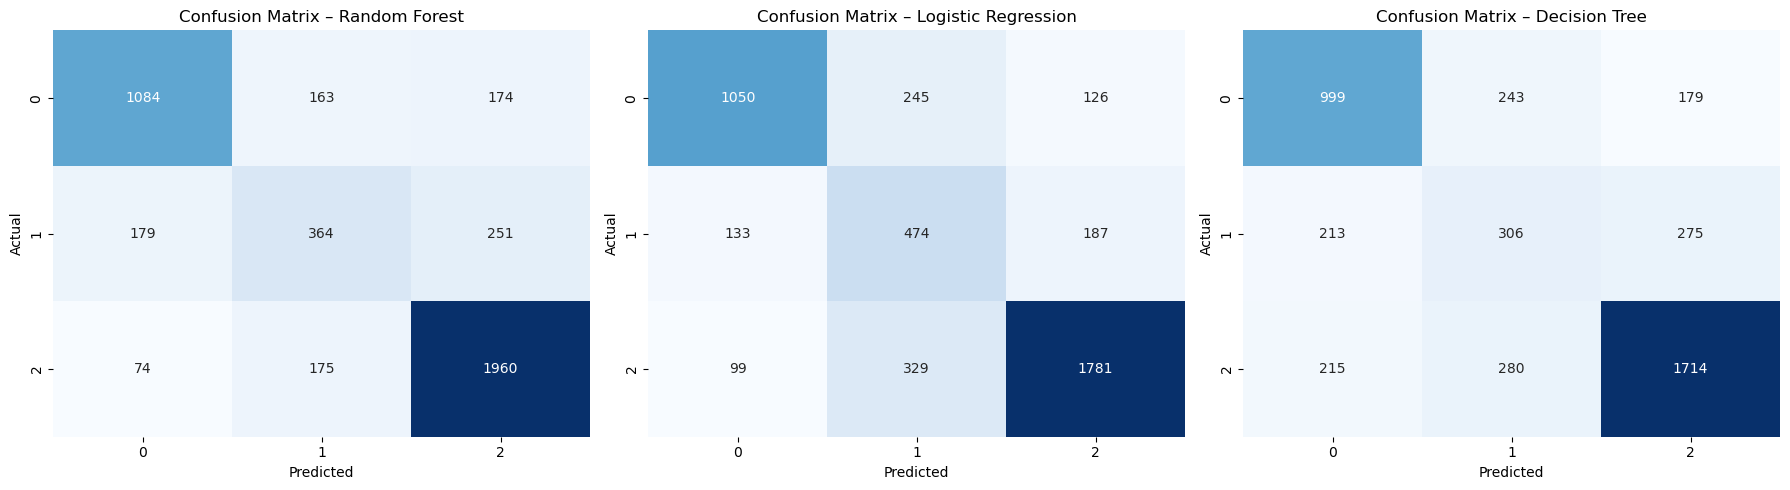

In [13]:
from sklearn.ensemble import RandomForestClassifier
# , AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon
#from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from FeaturesTrasformer import FeaturesTransformer
from preprocessor import preprocessor


X = stud_selected.drop(columns=['Target_encoded']) 
y = stud_selected['Target_encoded']  

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(),
    # 'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Bagging': BaggingClassifier(random_state=42),
    # 'Bayesian': GaussianNB(),
    #'XGBoost': XGBClassifier(random_state=42)
}

# Define scoring metrics for cross_validate
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc' ]

# Perform cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize dictionaries to store results
model_scores = {}      # To store per-fold scores for statistical tests
roc_curves = {}        # To store ROC curve data for each model
conf_matrices = {}     # To store confusion matrices for each model
all_results  = []
conf_matrices = {}
roc_curves    = {}

all_results = []

# Esegui TimeSeriesSplit per ognuno dei modelli
for model_name, model in models.items():
    
    pipeline = Pipeline(steps=[
        ('feature_transformer', FeaturesTransformer(drop_originals=True)),
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    y_true = []
    y_pred = []
    y_prob = []



    # Custom cross-validation loop
    # Iterate over the 5 folds
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        # Select training and validation subsets using the indices
        X_train = X.iloc[train_index]
        X_test= X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test= y.iloc[test_index]
         # --- debug ---
        print(f"Fold {fold}: type(X_train) =", type(X_train))
        # ------------- 

        # Fit the pipeline on the training fold
        pipeline.fit(X_train, y_train)
        
        # Predict on test data
        y_pred_fold = pipeline.predict(X_test)
        y_prob_fold = pipeline.predict_proba(X_test)[:, 1]
        
        # Store results
        y_true.extend(y_test)
        y_pred.extend(y_pred_fold)
        y_prob.extend(y_prob_fold)
    
    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

      # -------- overall metrics (macro & weighted) ------------------
    metrics = {
        "Model"            : model_name,
        "Accuracy"         : accuracy_score(y_true, y_pred),
        "Precision_macro"  : precision_score(y_true, y_pred, average="macro",  zero_division=0),
        "Recall_macro"     : recall_score(y_true, y_pred,   average="macro",  zero_division=0),
        "F1_macro"         : f1_score(y_true, y_pred,       average="macro",  zero_division=0),
        "Precision_weight" : precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Recall_weight"    : recall_score(y_true, y_pred,    average="weighted", zero_division=0),
        "F1_weight"        : f1_score(y_true, y_pred,        average="weighted", zero_division=0),
        # "ROC_AUC_macro"    : roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro"),
        # "ROC_AUC_weight"   : roc_auc_score(y_true, y_prob, multi_class="ovr", average="weighted"),
    }
    all_results.append(metrics)

    # -------- confusion matrix ------------------------------------
    conf_matrices[model_name] = confusion_matrix(y_true, y_pred)

    # -------- ROC curve (one-vs-rest for each class) --------------
    # fpr = {}
    # tpr = {}
    # roc_auc = {}
    # n_classes = y_prob.shape[1]
    # for cls in range(n_classes):
    #     fpr[cls], tpr[cls], _ = roc_curve(
    #         (y_true == cls).astype(int), y_prob[:, cls]
    #     )
    #     roc_auc[cls] = roc_auc_score(
    #         (y_true == cls).astype(int), y_prob[:, cls]
    #     )
    # roc_curves[model_name] = (fpr, tpr, roc_auc)

# ------------------------------------------------------------------
#  ❱ 2) Tabular results
# ------------------------------------------------------------------
results_df = pd.DataFrame(all_results)
display(results_df)                # Jupyter / IPython
# or:print(results_df.to_string(index=False))

# ------------------------------------------------------------------
#  ❱ 3) Plot ROC curves (one figure per model, all classes inside)
# ------------------------------------------------------------------
import matplotlib.cm as cm

for model_name, (fpr_dict, tpr_dict, roc_auc_dict) in roc_curves.items():
    plt.figure(figsize=(7, 6))
    colors = cm.Set1(np.linspace(0, 1, len(fpr_dict)))
    for cls, color in zip(fpr_dict.keys(), colors):
        plt.plot(
            fpr_dict[cls], tpr_dict[cls],
            label=f"Class {cls} (AUC = {roc_auc_dict[cls]:.2f})",
            color=color
        )
    plt.plot([0, 1], [0, 1], "k--", linewidth=0.8)
    plt.title(f"ROC curves – {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
#  ❱ 4) Plot all confusion matrices in a grid
# ------------------------------------------------------------------
num_models = len(conf_matrices)
cols = 3
rows = int(np.ceil(num_models / cols))

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
axes = np.atleast_2d(axes).flatten()

for ax, (model_name, cmat) in zip(axes, conf_matrices.items()):
    sns.heatmap(
        cmat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax
    )
    ax.set_title(f"Confusion Matrix – {model_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# remove empty subplots
for ax in axes[len(conf_matrices):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [9]:
metrics

{'Model': 'Random Forest',
 'Accuracy': 0.7778028933092225,
 'Precision_macro': 0.727202857670825,
 'Recall_macro': 0.710737632801851,
 'F1_macro': 0.7173884656263083,
 'Precision_weight': 0.7708806766578998,
 'Recall_weight': 0.7778028933092225,
 'F1_weight': 0.7729258446384801}

In [7]:
out = pipeline.named_steps["feature_transformer"].fit_transform(X_train)
print(type(out))
# >>> <class 'pandas.core.frame.DataFrame'>


<class 'pandas.core.frame.DataFrame'>
